<h1><left>EN-BOT: Predicting whether a Block goes En-Bloc!</left></h1>
<h1><left>3 DATA CLEANING AND EDA</left></h1>


<h4><left>by Samuel He</left></h4>

---


### OUTSIDE RESEARCH:
- Rumoured reasons?



### EDA Summary

- 0) General Exploration of our data. 

- 1) Break down into Training Set and Unseen Set.

- 2) Look at heights of blocks 

- 3) What are some trends in the knocking down of HDB blocks?

- 4) If we have time we should bring out all the demo blocks to look at them. 

-xxx

-xxx


### Feature Engineering Summary

- 1) Make a decision about age_announced

- 2)proximity to Airbases(means cannot build higher)

- 3) proximity to multistorey carparks (means that place has already been used efficiently) Important that the year the multistorey carpark was built must be consider) There is a carparks dataset online

- 4) proximity to an open air carpark?

- 5) proximity to MRT(Assumption that the HDB wants to maximize the amount of flats clustered around an MRT station. 


- 5) Density(how many flats built witin XX area around it. important that we take into account only the blocks from the same generation)


- 6) the average height of the five closest blocks to it that's built within 5 years of the same building
- 
- 
- 
- 
- 


In [27]:
# MUST-HAVE LIBRARIES
import time
from random import randint
from random import randint
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Magic to create Hi-Res PLT Plots

# GEOSPATIAL LIBRARIES
from geopy.distance import lonlat, distance
from math import sin, cos, sqrt, atan2, radians
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
from geopy.distance import geodesic
import shapely
from shapely import geometry
from shapely import ops
from shapely.geometry import Point, LineString, Polygon, MultiPoint, shape,mapping
from shapely.ops import nearest_points
from shapely.geometry import Point

#Uncomment to download Geopandas
#!pip3 install --upgrade --target=/Users/samuelhe/opt/anaconda3/lib/python3.7/site-packages geopandas
#Uncomment to download imblearn
#!pip3 install --upgrade --target=/Users/samuelhe/opt/anaconda3/lib/python3.7/site-packages imblearn

In [3]:
#READING IN CSVs
stand_blocks_latlon = pd.read_csv("../data/stand_blocks_latlon.csv")
demo_blocks_latlon = pd.read_csv("../data/demo_blocks_latlon.csv")


## 3.1 Data Cleaning

In [25]:
# QUICK AND DIRTY EDA CODE
# CREDITS: https://github.com/zzeniale
# getting some basic information about each dataframe

def basic_eda(df, df_name):
    print("[", df_name.upper(),"]\n")
    print(f"Rows: {df.shape[0]} \t Columns: {df.shape[1]}")
    print()
    
    print(f"Total null rows: {df.isnull().sum().sum()}")
    print(f"Percentage null rows: {round(df.isnull().sum().sum() / df.shape[0] * 100, 2)}%")
    print()
    
    print(f"Total duplicate rows: {df[df.duplicated(keep=False)].shape[0]}")
    print(f"Percentage dupe rows: {round(df[df.duplicated(keep=False)].shape[0] / df.shape[0] * 100, 2)}%")
    print()
    
    print(df.info())
    print("-----\n")

In [26]:
# CREATING A LIST OF TUPLES
dfs = [
    (stand_blocks_latlon, 'standing blocks'),
    (demo_blocks_latlon, 'demolished blocks')
    ]

# CALLING THE FUNCTION ON OUR LIST 
[basic_eda(df, name) for df, name in dfs]

[ STANDING BLOCKS ]

Rows: 12200 	 Columns: 27

Total null rows: 1
Percentage null rows: 0.01%

Total duplicate rows: 0
Percentage dupe rows: 0.0%

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12200 entries, 0 to 12199
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   year_completed        12200 non-null  float64
 1   blk_no                12200 non-null  object 
 2   street                12200 non-null  object 
 3   bldg_contract_town    12200 non-null  object 
 4   max_floor_lvl         12200 non-null  float64
 5   1room_sold            12200 non-null  float64
 6   2room_sold            12200 non-null  float64
 7   3room_sold            12200 non-null  float64
 8   4room_sold            12200 non-null  float64
 9   5room_sold            12200 non-null  float64
 10  exec_sold             12200 non-null  float64
 11  total_dwelling_units  12200 non-null  float64
 12  age_announced         12

[None, None]

---

#### Cleaning out null and NIL values
- Our scraping process has introduced some NaNs and "NIL" values into the new columns in our dataset. 

In [34]:
# HUNTING DOWN OUR NULL VALUES
demo_blocks_latlon[demo_blocks_latlon.BLK_NO.isnull()]

,year_completed,blk_no,street,bldg_contract_town,max_floor_lvl,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,total_dwelling_units,age_announced,cluster,num_of_blocks,is_demolished,SEARCHVAL,BLK_NO,ROAD_NAME,BUILDING,ADDRESS,POSTAL,X,Y,LATITUDE,LONGITUDE,LONGTITUDE
8,1963.0,51,nile rd,bm,10.00,0.0,29.333333,90.000000,0.000000,0.000000,0.0,119.333333,34.0,"['51', '53', '54']",3.0,1,HAVELOCK VIEW,NaN,NIL,HAVELOCK VIEW,HAVELOCK VIEW,NIL,27455.528133,30249.643075,1.289842,103.828426,103.828426
27,1973.0,6,yung ping rd,jw,11.00,0.0,0.000000,101.666667,0.000000,1.500000,0.0,103.166667,33.0,"['5', '6', '7', '8', '9', '10']",6.0,1,NIL,NaN,YUNG PING ROAD,NIL,NIL,NIL,15682.806702,34654.563948,1.329676,103.722642,103.722642
54,1976.0,11,ghim moh rd,qt,14.67,0.0,0.000000,79.000000,87.833333,0.833333,0.0,167.666667,30.0,"['9', '10', '11', '12', '9a', '12a']",6.0,1,11359 (BUS STOP),NaN,GHIM MOH RD,11359 (BUS STOP),GHIM MOH RD,NIL,23144.111978,32402.432683,1.309310,103.789686,103.789686
55,1976.0,12,ghim moh rd,qt,14.67,0.0,0.000000,79.000000,87.833333,0.833333,0.0,167.666667,30.0,"['9', '10', '11', '12', '9a', '12a']",6.0,1,12129 (BUS STOP),NaN,GHIM MOH RD,12129 (BUS STOP),GHIM MOH RD,NIL,22881.474201,32680.078174,1.311821,103.787326,103.787326
134,1983.0,1a,woodlands centre rd,wl,4.00,0.0,0.000000,71.500000,0.000000,2.000000,0.0,73.500000,29.0,"['1a', '2a']",2.0,1,NIL,NaN,WOODLANDS CENTRE ROAD,NIL,NIL,NIL,21062.848422,47059.406937,1.441867,103.770981,103.770981


In [39]:
# THE NULLS WERE CREATED BY OUR SCRAPED DATA FROM ONEMAPSG
demo_blocks_latlon.fillna("NIL", inplace=True)

In [41]:
# DECISION: LET'S IMPUTE THESE COLUMNS WITH "NIL"
demo_blocks_latlon[demo_blocks_latlon.BLK_NO.str.contains("NIL")]

,year_completed,blk_no,street,bldg_contract_town,max_floor_lvl,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,total_dwelling_units,age_announced,cluster,num_of_blocks,is_demolished,SEARCHVAL,BLK_NO,ROAD_NAME,BUILDING,ADDRESS,POSTAL,X,Y,LATITUDE,LONGITUDE,LONGTITUDE
8,1963.0,51,nile rd,bm,10.00,0.0,29.333333,90.000000,0.000000,0.000000,0.0,119.333333,34.0,"['51', '53', '54']",3.0,1,HAVELOCK VIEW,NIL,NIL,HAVELOCK VIEW,HAVELOCK VIEW,NIL,27455.528133,30249.643075,1.289842,103.828426,103.828426
27,1973.0,6,yung ping rd,jw,11.00,0.0,0.000000,101.666667,0.000000,1.500000,0.0,103.166667,33.0,"['5', '6', '7', '8', '9', '10']",6.0,1,NIL,NIL,YUNG PING ROAD,NIL,NIL,NIL,15682.806702,34654.563948,1.329676,103.722642,103.722642
54,1976.0,11,ghim moh rd,qt,14.67,0.0,0.000000,79.000000,87.833333,0.833333,0.0,167.666667,30.0,"['9', '10', '11', '12', '9a', '12a']",6.0,1,11359 (BUS STOP),NIL,GHIM MOH RD,11359 (BUS STOP),GHIM MOH RD,NIL,23144.111978,32402.432683,1.309310,103.789686,103.789686
55,1976.0,12,ghim moh rd,qt,14.67,0.0,0.000000,79.000000,87.833333,0.833333,0.0,167.666667,30.0,"['9', '10', '11', '12', '9a', '12a']",6.0,1,12129 (BUS STOP),NIL,GHIM MOH RD,12129 (BUS STOP),GHIM MOH RD,NIL,22881.474201,32680.078174,1.311821,103.787326,103.787326
134,1983.0,1a,woodlands centre rd,wl,4.00,0.0,0.000000,71.500000,0.000000,2.000000,0.0,73.500000,29.0,"['1a', '2a']",2.0,1,NIL,NIL,WOODLANDS CENTRE ROAD,NIL,NIL,NIL,21062.848422,47059.406937,1.441867,103.770981,103.770981


In [107]:
# CHECKING OUT NIL ENTRIES IN DEMOLISHED BLOCKS

print("PERCENTAGE OF NIL ENTRIES IN COLUMNS\n","-"*33, "\n")
for col in demo_blocks_latlon.columns:
    percent_nils = demo_blocks_latlon[col].astype(str).str.contains("NIL").mean()
    #print(demo_blocks_latlon[col].astype(str).str.contains("NIL").mean())
    if percent_nils > 0:
        print( col,":", percent_nils)

PERCENTAGE OF NIL ENTRIES IN COLUMNS
 --------------------------------- 

SEARCHVAL : 0.011428571428571429
BLK_NO : 0.02857142857142857
ROAD_NAME : 0.005714285714285714
BUILDING : 0.14285714285714285
ADDRESS : 0.011428571428571429
POSTAL : 0.03428571428571429


In [106]:
# CHECKING OUT NIL ENTRIES IN STANDING BLOCKS

print("PERCENTAGE OF NIL ENTRIES IN COLUMNS\n","-"*33, "\n")
for col in stand_blocks_latlon.columns:
    percent_nils = stand_blocks_latlon[col].astype(str).str.contains("NIL").mean()
    
    if percent_nils > 0:
        
        print(col,":", percent_nils)

PERCENTAGE OF NIL ENTRIES IN COLUMNS
 --------------------------------- 

ROAD_NAME : 0.0003278688524590164
BUILDING : 0.08622950819672132
ADDRESS : 0.0002459016393442623
POSTAL : 0.0010655737704918034


> **Data Cleaning Decision** : The most important detail we needed from OneMapsSG was the Lat-Lon figures. We should be able the comfortably remove the other columns we extracted from the API. That'll also get rid of our "NIL" entries in those columns. We'll also drop the mis-spelled "LONGTITUDE" column as that is an extra column that came with the API.

In [109]:
stand_blocks_latlon.columns

Index(['year_completed', 'blk_no', 'street', 'bldg_contract_town',
       'max_floor_lvl', '1room_sold', '2room_sold', '3room_sold', '4room_sold',
       '5room_sold', 'exec_sold', 'total_dwelling_units', 'age_announced',
       'cluster', 'num_of_blocks', 'is_demolished', 'SEARCHVAL', 'BLK_NO',
       'ROAD_NAME', 'BUILDING', 'ADDRESS', 'POSTAL', 'X', 'Y', 'LATITUDE',
       'LONGITUDE', 'LONGTITUDE'],
      dtype='object')

In [112]:
# REMOVING "USELESS" FEATURES
stand_blocks_clean = stand_blocks_latlon.drop(['SEARCHVAL', 'BLK_NO','ROAD_NAME', 
                                               'BUILDING', 'ADDRESS', 'POSTAL', 
                                               'X', 'Y','LONGTITUDE'], axis="columns")

demo_blocks_clean = demo_blocks_latlon.drop(['SEARCHVAL', 'BLK_NO','ROAD_NAME', 
                                               'BUILDING', 'ADDRESS', 'POSTAL', 
                                               'X', 'Y','LONGTITUDE'], axis="columns")

In [115]:
# CHANGING COLUMN NAMES TO LOWERCASE
demo_blocks_clean.columns = [col.lower() for col in demo_blocks_clean.columns]

stand_blocks_clean.columns = [col.lower() for col in stand_blocks_clean.columns]

> **Cleaned!** : We are ready to start our EDA process!

## 3.2 Exploring our "Standing Blocks" dataset

In [116]:
pd.set_option('display.max_columns', 500)
stand_blocks_clean.head(2)

,year_completed,blk_no,street,bldg_contract_town,max_floor_lvl,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,total_dwelling_units,age_announced,cluster,num_of_blocks,is_demolished,latitude,longitude
0,1999.0,356a,admiralty dr,sb,16.0,0.0,0.0,0.0,57.0,28.0,0.0,85.0,21.0,"['356a', '356b', '356c', '357', '357a', '357b'...",23.0,0,1.449441,103.816852
1,1999.0,356b,admiralty dr,sb,16.0,0.0,0.0,0.0,32.0,55.0,26.0,113.0,21.0,"['356a', '356b', '356c', '357', '357a', '357b'...",23.0,0,1.449229,103.817376


In [117]:
stand_blocks_clean.describe()

,year_completed,max_floor_lvl,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,total_dwelling_units,age_announced,num_of_blocks,is_demolished,latitude,longitude
count,12200.000000,12200.000000,12200.000000,12200.000000,12200.000000,12200.000000,12200.000000,12200.000000,12200.000000,12200.000000,12200.000000,12200.0,12200.000000,12200.000000
mean,1993.050738,11.988033,0.020902,2.033115,19.785656,34.578770,19.896393,5.306393,87.552377,26.949262,12.346393,0.0,1.365352,103.840217
std,13.612720,6.950743,2.308662,12.608069,45.421487,40.706899,29.893026,17.604262,65.451573,13.612720,10.143879,0.0,0.042583,0.073228
min,1937.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.0,1.270380,103.685228
25%,1984.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36.750000,19.000000,5.000000,0.0,1.336524,103.775159
50%,1993.000000,12.000000,0.000000,0.000000,0.000000,22.000000,0.000000,0.000000,90.000000,27.000000,9.000000,0.0,1.363234,103.845497
75%,2001.000000,16.000000,0.000000,0.000000,6.000000,58.000000,40.000000,0.000000,120.000000,36.000000,17.000000,0.0,1.392390,103.898523
max,2019.000000,50.000000,255.000000,225.000000,528.000000,316.000000,164.000000,135.000000,584.000000,83.000000,54.000000,0.0,1.456732,103.988706


In [ ]:
sns.pairplot(stand_blocks_clean);

In [6]:
plt.figure(figsize=(12,8), dpi=500)


# STANDING BLOCKS AS 1200 PURPLE DOTS
sns.scatterplot(stand_blocks_latlon['LONGITUDE'], stand_blocks_latlon['LATITUDE'], marker='o', 
                hue=stand_blocks_latlon["year_completed"],
               sizes=(2, 500), palette="Purples", alpha=0.2, legend=None);

# DEMOLISHED BLOCKS AS 175 RED CROSSES
sns.scatterplot(demo_blocks_latlon['LONGITUDE'], demo_blocks_latlon['LATITUDE'], marker='P', 
                    hue=demo_blocks_latlon["year_completed"],size=demo_blocks_latlon["year_completed"],
               sizes=(50, 200), palette="Reds", alpha=0.9, legend="full");

In [114]:
demo_blocks_latlon.describe()

,year_completed,max_floor_lvl,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,total_dwelling_units,age_announced,num_of_blocks,is_demolished,X,Y,LATITUDE,LONGITUDE,LONGTITUDE
count,175.000000,175.000000,175.0,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.0,175.000000,175.000000,175.000000,175.000000,175.000000
mean,1967.851429,10.036343,0.0,5.565714,74.891429,23.862857,2.131429,0.057143,106.508571,40.337143,12.405714,1.0,24215.196912,32594.314599,1.311045,103.799310,103.799310
std,9.369839,3.264492,0.0,10.975371,45.695139,39.862839,5.500655,0.253060,54.065872,11.873642,10.234097,0.0,5316.909454,3232.105350,0.029230,0.047775,0.047775
min,1950.000000,3.500000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000,18.000000,1.000000,1.0,14004.972729,28724.469189,1.276048,103.707565,103.707565
25%,1962.000000,8.000000,0.0,0.000000,41.666667,0.142857,0.000000,0.000000,74.000000,30.000000,5.000000,1.0,20759.651237,30261.215161,1.289946,103.768261,103.768261
50%,1973.000000,9.500000,0.0,0.000000,81.903226,4.923077,0.000000,0.000000,112.258065,37.000000,7.000000,1.0,24223.652518,31579.132751,1.301865,103.799386,103.799386
75%,1976.000000,12.500000,0.0,0.000000,99.333333,22.000000,1.400000,0.000000,131.857143,52.000000,21.000000,1.0,27589.791143,33714.325219,1.321173,103.829633,103.829633
max,1983.000000,17.000000,0.0,29.333333,374.000000,169.000000,25.000000,1.285714,374.000000,57.000000,31.000000,1.0,38108.592746,47059.406937,1.441867,103.924150,103.924150


In [115]:
#SINCE THE YOUNGEST BLOCK IN THE DEMOLISHED DATASET WAS BUILT IN 1983.... 
#....LETS TRY BUILDING A TRAINING SET OF ALL BLOCKS BUILT BEFORE 1984...
#....These blocks are the survivors...
survivor_blocks_latlon = stand_blocks_latlon[stand_blocks_latlon["year_completed"]<=1983]

In [116]:
#OUR UNSEEN TEST SET: WILL BE WHAT WAS BUILT FROM 1984
from1984_blocks = stand_blocks_latlon[stand_blocks_latlon["year_completed"]>1983]

In [117]:
# OUR TRAINING SET: ALL BLOCKS BUILT BEFORE 1983 (NOTE: SOME ARE DEMOLISHED)
before1984_blocks = pd.concat([survivor_blocks_latlon,demo_blocks_latlon ])

In [118]:
#DESCRIBING before1984_blocks
# Worth checking what the standard deviation for some of the room types is so high. 
before1984_blocks.describe()

,year_completed,max_floor_lvl,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,total_dwelling_units,age_announced,num_of_blocks,is_demolished,X,Y,LATITUDE,LONGITUDE,LONGTITUDE
count,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000
mean,1975.122099,11.537080,0.091039,2.537308,60.750089,27.322742,11.776151,0.952160,118.380221,44.139950,10.846483,0.062478,28998.275280,34798.139695,1.330976,103.842289,103.842289
std,8.027414,5.786618,4.818187,12.068868,73.519769,44.060573,28.893248,7.524277,76.330257,8.073704,9.913591,0.242064,6993.276970,3791.985625,0.034293,0.062839,0.062839
min,1937.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,1.000000,0.000000,14004.972729,28097.635137,1.270380,103.707565,103.707565
25%,1973.000000,9.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,83.000000,39.000000,4.000000,0.000000,24267.565672,32093.189809,1.306513,103.799781,103.799781
50%,1977.000000,12.000000,0.000000,0.000000,23.000000,4.000000,0.000000,0.000000,116.000000,42.000000,7.000000,0.000000,29409.763097,34482.004614,1.328117,103.845986,103.845986
75%,1980.000000,14.000000,0.000000,0.000000,112.000000,30.000000,2.000000,0.000000,153.000000,46.000000,15.000000,0.000000,33917.064744,36945.238947,1.350391,103.886487,103.886487
max,1983.000000,27.000000,255.000000,225.000000,528.000000,316.000000,134.000000,125.000000,570.000000,83.000000,54.000000,1.000000,45292.592743,47694.700702,1.447608,103.988706,103.988706


In [119]:
#DESCRIBING from1984_blocks
from1984_blocks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9574 entries, 0 to 12198
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   year_completed        9574 non-null   float64
 1   blk_no                9574 non-null   object 
 2   street                9574 non-null   object 
 3   bldg_contract_town    9574 non-null   object 
 4   max_floor_lvl         9574 non-null   float64
 5   1room_sold            9574 non-null   float64
 6   2room_sold            9574 non-null   float64
 7   3room_sold            9574 non-null   float64
 8   4room_sold            9574 non-null   float64
 9   5room_sold            9574 non-null   float64
 10  exec_sold             9574 non-null   float64
 11  total_dwelling_units  9574 non-null   float64
 12  age_announced         9574 non-null   float64
 13  cluster               9574 non-null   object 
 14  num_of_blocks         9574 non-null   float64
 15  is_demolished       

## DROPPING COLUMNS

In [120]:
# LETS TRY WITHOUT DUMMIES

#before1984_blocks = pd.get_dummies(data=before1984_blocks, columns=[ "bldg_contract_town"], drop_first=True)

In [121]:
#DECIDE WHAT TO DROP, THEN GET DUMMIES FROM EVBERYTHING ELSE
#CREATING A DATAFRAME WITH ONLY NUMBERS
before1984_blocks_prep = before1984_blocks.select_dtypes(exclude=['object'])


In [122]:
#Checking out our baseline score to beat
# In our dataset, we have 6percent of our blocks built before 1984 which have been demolished
before1984_blocks_prep.is_demolished.value_counts(normalize=True)


0    0.937522
1    0.062478
Name: is_demolished, dtype: float64

In [123]:
before1984_blocks_prep.columns

Index(['year_completed', 'max_floor_lvl', '1room_sold', '2room_sold',
       '3room_sold', '4room_sold', '5room_sold', 'exec_sold',
       'total_dwelling_units', 'age_announced', 'num_of_blocks',
       'is_demolished', 'X', 'Y', 'LATITUDE', 'LONGITUDE', 'LONGTITUDE'],
      dtype='object')

In [124]:
#DEFINING OUR TARGET AND PREDICTORS
#DROPPING LOCATION DATA AS THAT PREVENTS THE MODEL FROM GENERALISING WELL
X = before1984_blocks_prep.drop(["year_completed", 'is_demolished', 'X', 'Y', 'LONGTITUDE'],axis=1)
y = before1984_blocks_prep['is_demolished']

In [125]:
#USING SIMILAR METHODS, WE ARE...
#...PREPPING A UNSEEN DATA SET OF BLOCKS THAT WE KNOCKED DOWN ONLY AFTER 1984
from1984_blocks_prep =from1984_blocks.select_dtypes(exclude=['object'])
X_val = from1984_blocks_prep.drop(["year_completed", 'is_demolished', 'X', 'Y', 'LONGTITUDE'],axis=1)

## LIGHTNING MODELLING
We're just going to dump *before1984_blocks* into a model to see if there's any kind of results we can get from there. 

In [126]:
df_list = []

In [127]:
# DEFINING A FUNCTION THAT WILL RUN MULTIPLE MODELS AND GRIDSEARCH FOR BEST PARAMETERS
# NOTE: X and y MUST BE DEFINED PRIOR TO FUNCTION
# NOTE: AN EMPTY LIST NAMED df_list MUST BE DEFINED PRIOR TO FUNCTION

def gridsearch_multi(steps_titles, steps_list, pipe_params):
    #TRAIN-TEST SPLIT
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=25, stratify=y)
    # DATAFRAME TO DISPLAY RESULTS
    gs_results = pd.DataFrame(columns=['model','AUC Score', 'precision', 'recall', 
                                       'best_params', 'best score', 'confusion matrix', 
                                       'train_accuracy','test_accuracy','baseline_accuracy', 'f1-score'])

    # FOR LOOP THROUGH STEPS LIST
    for i in range(len(steps_list)):
        # INSTATIATE PIPELINE
        pipe = Pipeline(steps=steps_list[i])
        # INSTANTIATE GRIDSEARCHCV WITH PARAMETER ARGUMENT
        gs = GridSearchCV(pipe, pipe_params[i], cv=3) 
        gs.fit(X_train, y_train)
        
        #GETTING PREDICTIONS FROM MODEL
        pred = gs.predict(X_test)
        
        # DEFINE CONFUSION MATRIX ELEMENTS
        tn, fp, fn, tp = confusion_matrix(y_test, gs.predict(X_test)).ravel() 
        
        #CALCULATING AREA UNDER THE CURVE 
        auc = roc_auc_score(y_test, pred)
        recall=tp/(tp+fp)
        precision=tp/(tn+tp)
        #DEFINE DATAFRAME COLUMNS
        model_results = {}
        model_results['model'] = steps_titles[i]
        model_results['AUC Score'] = auc
        model_results['recall (sensitivity)']= recall
        model_results['best params'] = gs.best_params_
        model_results['best score'] = gs.best_score_
        model_results['confusion matrix']={"TP": tp,"FP":fp, "TN": tn, "FN": fn}
        model_results['train accuracy'] = gs.score(X_train, y_train)
        model_results['test accuracy'] = gs.score(X_test, y_test)
        model_results['baseline accuracy'] = 0.938 # Change this according to baseline        
        model_results['precision']= precision
        model_results['f1-score']= 2*(recall*precision)/(recall+precision)


        #APPEND RESULTS TO A NICE DATAFRAME
        df_list.append(model_results) 
        pd.set_option("display.max_colwidth", 200)
    return (pd.DataFrame(df_list)).round(2)

In [128]:
#GIANT LIST OF TEST MODELS


steps_titles = ['GradientTrees', "SVM", 'SS+PCA+SVM',
               'multi_nb','ss + knn','ss + logreg']

# CODE FOR PIPELINE TO INSTATIATE MODELS
steps_list = [ [('trees', GradientBoostingClassifier(random_state=25,n_estimators=50,max_depth=3,
                             min_samples_leaf=2))],
                 # need to set balance because we have imblanced classes
              [('svc', SVC(random_state=25,class_weight='balanced',gamma='auto'))], 
              [('ss',StandardScaler()),('pca',PCA(1)),('svc', SVC(random_state=25,
                class_weight='balanced',gamma='auto',kernel='rbf'))],
              [('multi_nb', MultinomialNB())],
              [('scaler', StandardScaler(with_mean=False)),('knn', KNeighborsClassifier())], 
              [('scaler', StandardScaler(with_mean=False)),('logreg', LogisticRegression(max_iter = 350))]
]

# LIST OF PARAMETER DICTIONARIES
pipe_params = [
    {'trees__learning_rate':np.linspace(0.1,1,3),'trees__max_features':['sqrt',None]},
    {'svc__C':np.linspace(0.01,1,3),'svc__kernel':['linear','rbf']},
    {'svc__C':np.linspace(0.01,1,3)},
    {},
    {},
    {}]


In [129]:
%%time
gridsearch_multi(steps_titles, steps_list, pipe_params)

CPU times: user 39 s, sys: 518 ms, total: 39.5 s
Wall time: 35.7 s


/Users/samuelhe/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in long_scalars


,model,AUC Score,recall (sensitivity),best params,best score,confusion matrix,train accuracy,test accuracy,baseline accuracy,precision,f1-score
0,GradientTrees,1.00,0.96,"{'trees__learning_rate': 0.55, 'trees__max_features': 'sqrt'}",1.00,"{'TP': 44, 'FP': 2, 'TN': 655, 'FN': 0}",1.00,1.00,0.94,0.06,0.12
1,SVM,0.97,1.00,"{'svc__C': 0.505, 'svc__kernel': 'rbf'}",0.99,"{'TP': 41, 'FP': 0, 'TN': 657, 'FN': 3}",1.00,1.00,0.94,0.06,0.11
2,SS+PCA+SVM,0.55,0.08,{'svc__C': 0.01},0.84,"{'TP': 16, 'FP': 173, 'TN': 484, 'FN': 28}",0.70,0.71,0.94,0.03,0.05
3,multi_nb,0.68,0.10,{},0.51,"{'TP': 39, 'FP': 342, 'TN': 315, 'FN': 5}",0.51,0.50,0.94,0.11,0.11
4,ss + knn,0.94,0.89,{},0.99,"{'TP': 39, 'FP': 5, 'TN': 652, 'FN': 5}",0.99,0.99,0.94,0.06,0.11
5,ss + logreg,0.50,NaN,{},0.94,"{'TP': 0, 'FP': 0, 'TN': 657, 'FN': 44}",0.94,0.94,0.94,0.00,NaN


In [130]:
# gradient Trees Worked best
# SO lets try 
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=25, stratify=y)

# ss= StandardScaler()
# X_ss= ss.fit_transform(X)


# "PRODUCTION MODEL" CHOSEN: GRADIENT TREES

In [131]:
# gradient Trees Worked best
gb=GridSearchCV(GradientBoostingClassifier(n_estimators=500,max_depth=3,random_state=42),
                {'learning_rate':np.linspace(0.1,1,3),'max_features':['sqrt',None]},scoring='roc_auc')            
gb.fit(X,y)

GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=500,
                                                  n_iter_no_change=None,
      

In [132]:
tn, fp, fn, tp = confusion_matrix(y, gb.predict(X_ss)).ravel() 
(tn, fp, fn, tp)

(2626, 0, 0, 175)

In [133]:
gb.best_estimator_

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [134]:
features=gb.best_estimator_.feature_importances_

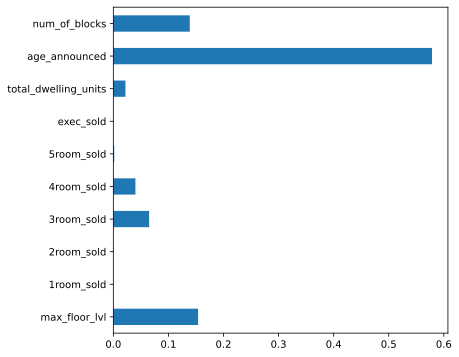

In [135]:
plt.figure(figsize=(6,6))
pd.Series(features,index=X.columns).plot(kind='barh');

# USING OUR MODEL ON UNSEEN DATA
With our model trained up, let's try to use it on all standing blocks built after 1984. 

The results of this predictions can be written out in this manner...
Based on the the Housing Development Board's previous demolition strategy, which blocks might make the cut to be demolished in 2020. 

*Assumptions: We will not include the pre-1984 blocks that "survived". (We should do some EDA to see whether surviving means you survive forever)*

In [136]:
#OUR UNSEEN TEST SET: WILL BE WHAT WAS BUILT FROM 1984
from1984_blocks = stand_blocks_latlon[stand_blocks_latlon["year_completed"]>1983]

In [137]:
#USING SIMILAR METHODS, WE ARE...
#...PREPPING A UNSEEN DATA SET OF BLOCKS THAT WE KNOCKED DOWN ONLY AFTER 1984
from1984_blocks_prep =from1984_blocks.select_dtypes(exclude=['object'])
X_val = from1984_blocks_prep.drop(["year_completed", 'is_demolished', 'X', 'Y', 'LATITUDE', 'LONGITUDE', 'LONGTITUDE'],axis=1)




In [138]:
# #THIS SHOULD NOT BE THE WAY, BUT I'M JUST TRYING TO SHOE HORN THE SCALE OF THE YEARS
# # THIS SHOULD RIGHTLY BE DONE USING MINMAX SCALER I THINK
# # EITHER THAT OR WE ADD A FUNCTION TO ASK WHAT YEAR ARE WE CHECKING THIS IN, THEN WE ADD THE YEAR TO AGE ANNOUNCED
#X_val.age_announced -= 40
X_ss_val= ss.transform(X_val)

In [139]:
gb.predict(X_ss_val)

array([1, 1, 1, ..., 1, 1, 1])

In [140]:
# CREATING A PREDICTIONS COLUMN
from1984_blocks["predictions"] = gb.predict(X_ss_val)

/Users/samuelhe/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [141]:
from1984_blocks["predictions"].sum()

9574

# CONCLUSION

- huh, our GRADIENT BOOSTED TREES model is predicting EVERYTHING AS DEMOLISHED!
- Nooooo.....

# LETS TRY OTHER TREE CLASSIFIERS...

# (BAGGING CLASSIFIER)

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=25, stratify=y)

# Instantiate BaggingClassifier.
bag = BaggingClassifier() #Inside the default Bagging Classifier is a Decision Tree Classifier)

# Fit BaggingClassifier.
bag.fit(X_train, y_train)

# Score BaggingClassifier.
bag.score(X_test, y_test)

0.9971469329529244

In [154]:
pd.DataFrame(bag.predict(X_val)).mean()

0    1.0
dtype: float64

>Hmmmm....Still sucks...it is predicting everything as demolished!

# (RANDOM FOREST CLASSIFIER)

In [164]:
?RandomForestClassifier

In [189]:
rf = RandomForestClassifier(min_samples_split=5, random_state = 42)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)


1.0

In [190]:
rf_predict = pd.DataFrame(rf.predict(X_val), columns=["preds"])

In [191]:
#Still horrible. but it didn't just predict everything as demolished. Worth looking into. 
rf_predict.preds.value_counts()

1    9275
0     299
Name: preds, dtype: int64

In [192]:
rf.predict(X_val)

array([1, 1, 1, ..., 1, 1, 1])

# (GRIDSEARCHED RANDOM FOREST CLASSIFIER)

In [202]:
#Let's try a GridSearch for RFs
rf_params = {
    "min_samples_split":[1,5,10,20,50],
    "n_estimators": [100, 150, 200],
    "max_depth": [None, 1, 2, 3, 4,5]
}

gs = GridSearchCV(rf, param_grid = rf_params, cv=5)
gs.fit(X_train, y_train)
print(gs.best_score_)

gs.best_params_

/Users/samuelhe/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/samuelhe/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/samuelhe/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integ

/Users/samuelhe/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/samuelhe/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/samuelhe/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integ

/Users/samuelhe/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/samuelhe/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/samuelhe/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integ

/Users/samuelhe/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/samuelhe/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/samuelhe/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integ

1.0


{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}

In [ ]:
gs.predict(X_val)

In [197]:
gs.best_estimator_.predict(X_val)

array([1, 1, 1, ..., 1, 1, 1])

In [200]:
best_predict = pd.DataFrame(gs.best_estimator_.predict(X_val), columns=["preds"])

In [201]:
best_predict.preds.value_counts()

1    9275
0     299
Name: preds, dtype: int64

# (ADABOOST)

In [214]:
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
ada_params = {
    'n_estimators': [50,100],
    'base_estimator__max_depth': [2,3, 5,10],
    'learning_rate': [.9, 1., 1.1,2.0]
}
gs = GridSearchCV(ada, param_grid=ada_params, cv=3)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

1.0


{'base_estimator__max_depth': 2, 'learning_rate': 1.1, 'n_estimators': 100}

In [215]:
ada_predict = pd.DataFrame(gs.best_estimator_.predict(X_val), columns=["preds"])

In [216]:
ada_predict.preds.value_counts()

1    6836
0    2738
Name: preds, dtype: int64

# (SMOTE TO OVERSAMPLE!)

In [224]:
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_sample(X_train, y_train)

In [225]:
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
ada_params = {
    'n_estimators': [50,100],
    'base_estimator__max_depth': [2,3, 5,10],
    'learning_rate': [.9, 1., 1.1,2.0]
}
gs = GridSearchCV(ada, param_grid=ada_params, cv=3)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.9997451580020388


{'base_estimator__max_depth': 3, 'learning_rate': 1.1, 'n_estimators': 50}

In [226]:
ada_predict = pd.DataFrame(gs.best_estimator_.predict(X_val), columns=["preds"])

In [227]:
ada_predict.preds.value_counts()

1    5846
0    3728
Name: preds, dtype: int64

# PLS IGNORE ALL CELLS BELOW

## OTHER THINGS WE NEED TO TRY
- Other models
- Look at the TP, FP, TN, FNs - My feeling is that these are important. Even what the model sees as wrong is important

## FEATURES THAT WE CAN ADD
- proximity to Airbases(means cannot build higher)
- proximity to multistorey carparks (means that place has already been used efficiently) Important that the year the multistorey carpark was built must be consider)
- There is a carparks dataset online
- proximity to MRT(Assumption that the HDB wants to maximize the amount of flats clustered around an MRT station. 
- Density(how many flats built witin XX area around it)
- the average height of the five closest blocks to it that's built within 5 years of the same building




## IGNORE EVERYTHING BELOW

In [33]:
gb=GridSearchCV(LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1),
                {"max_iter": [100, 200, 350]}, scoring='roc_auc')            
gb.fit(X_ss_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'max_iter': [100, 200, 350]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring='roc_auc',
             verbose=0)

In [34]:
features=gb.best_estimator_

In [35]:
features

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# PLS IGNORE

# ROUGH PAPER BELOW THIS LINE

---

In [36]:
#Creating a geospatial plot with the data above...
#...with hues and markersize showing which are the worst-hit streets
# mapdata = np.loadtxt("../data/mapdata_copyright_openstreetmap_contributors.txt")

# aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
# #Chicago_lon_lat_box = (-88, -87.5, 41.6, 42.1)

# lon_lat_box = (103.59, 104.14, 1.17, 1.46)

plt.figure(figsize=(20,14), dpi=500)

# plt.imshow(mapdata, 
#           cmap=plt.get_cmap('gray'),
#           extent=lon_lat_box,
#           aspect=aspect)
# plt.title('West Nile Virus repeatedly found on same sites in different years in Chicago', fontsize=12, c="darkred");

sns.scatterplot(demo_blocks_clean['LONGITUDE'], demo_blocks_clean['LATITUDE'], marker='P', 
                hue=demo_blocks_clean["year_completed"],
               sizes=(2, 500), palette="rainbow", alpha=0.5, legend="full");

NameError: name 'demo_blocks_clean' is not defined

<Figure size 10000x7000 with 0 Axes>

In [ ]:

import json
from shapely.geometry import shape, GeometryCollection

with open("../data/singapore-map-polygon/national-map-polygon-geojson.geojson") as f:
  features = json.load(f)["features"]

# NOTE: buffer(0) is a trick for fixing scenarios where polygons have overlapping coordinates 
GeometryCollection([shape(feature["geometry"]).buffer(0) for feature in features])